In [42]:
import pandas as pd
import numpy as np
from tqdm import tqdm
# Cài đặt các thư viện cần thiết nếu chưa có:
# pip install ta
# pip install pywavelets
from ta import add_all_ta_features
import pywt


In [81]:
def get_dollar_bars_impl(df, threshold):
    """
    Tự triển khai hàm get_dollar_bars.
    """
    df_iterator = df.itertuples()
    bars = []
    current_bar = {'date_time': None, 'open': 0, 'high': -np.inf, 'low': np.inf, 'close': 0, 'volume': 0, 'dollar_volume': 0}
    try:
        row = next(df_iterator)
        current_bar['date_time'], current_bar['open'] = row.date_time, row.close
    except StopIteration:
        return pd.DataFrame(bars)
    for row in df_iterator:
        current_bar['high'] = max(current_bar['high'], row.close)
        current_bar['low'] = min(current_bar['low'], row.close)
        current_bar['volume'] += row.volume
        dollar_value = row.close * row.volume
        current_bar['dollar_volume'] += dollar_value
        if current_bar['dollar_volume'] >= threshold:
            current_bar['close'] = row.close
            bars.append(current_bar.copy())
            current_bar = {'date_time': row.date_time, 'open': row.close, 'high': row.close, 'low': row.close, 'close': row.close, 'volume': 0, 'dollar_volume': 0}
    if current_bar['dollar_volume'] > 0:
        bars.append(current_bar)
    return pd.DataFrame(bars)

def get_frac_diff_weights(d, thres=1e-4):
    """
    Tự triển khai hàm tính trọng số cho Vi phân Bậc phân số (FFD).
    """
    w, k = [1.], 1
    while True:
        w_k = -w[-1] * (d - k + 1) / k
        if abs(w_k) < thres: break
        w.append(w_k)
        k += 1
    return np.array(w[::-1])

def frac_diff_ffd_impl(series, d, thres=1e-4):
    """
    Tự triển khai Vi phân Bậc phân số với cửa sổ mở rộng cố định (FFD).
    """
    weights = get_frac_diff_weights(d, thres)
    width = len(weights) - 1
    df_ = pd.Series(0., index=series.index)
    series_values = series.values.flatten()
    for i in range(width, len(series)):
        df_.iloc[i] = np.dot(weights, series_values[i - width : i + 1])
    return df_

def add_technical_indicators(df):
    """
    Hàm để thêm tất cả các chỉ báo kỹ thuật từ thư viện 'ta'.
    Đã được chỉnh sửa để làm việc với tên cột viết thường và loại bỏ FutureWarning.
    """
    df_copy = df.copy()
    df_copy.columns = [c.capitalize() for c in df_copy.columns]
    
    required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in required_cols:
        if col not in df_copy.columns:
            raise ValueError(f"Cột '{col}' không tồn tại trong DataFrame để tính TA.")

    print(f"  - Thêm các chỉ báo TA vào DataFrame có shape: {df_copy.shape}")

    df_with_ta = add_all_ta_features(
        df_copy, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
    )
    
    df_with_ta.columns = [c.lower() for c in df_with_ta.columns]

    df_with_ta.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_with_ta.ffill(inplace=True)
    df_with_ta.bfill(inplace=True)

    print(f"    -> Shape mới sau khi thêm chỉ báo TA: {df_with_ta.shape}")
    return df_with_ta

def apply_wavelet_transform(data, columns, wavelet='db4', level=1):
    """
    Áp dụng Discrete Wavelet Transform (DWT) lên các cột được chỉ định.
    """
    new_df = data.copy()
    print(f"  - Áp dụng Wavelet Transform (wavelet: {wavelet}) cho các cột: {columns}")
    
    for col in columns:
        if col not in new_df.columns:
            print(f"    -> Cảnh báo: Cột '{col}' không tồn tại để áp dụng wavelet, bỏ qua.")
            continue
        signal = new_df[col].values
        
        if len(signal) < pywt.Wavelet(wavelet).dec_len + level -1:
            print(f"    -> Dữ liệu quá ngắn cho cột '{col}' với level={level}, bỏ qua.")
            continue

        try:
            coeffs = pywt.dwt(signal, wavelet, mode='symmetric')
            cA, cD = coeffs  
            
            cA_padded = np.pad(cA, (0, len(signal) - len(cA)), 'edge')
            cD_padded = np.pad(cD, (0, len(signal) - len(cD)), 'edge')
            
            new_df[f'{col}_cA'] = cA_padded
            new_df[f'{col}_cD'] = cD_padded
        except Exception as e:
            print(f"    -> Lỗi khi áp dụng wavelet cho cột '{col}': {e}")
            
    return new_df

def get_triple_barrier_labels(close, t_events, pt_sl_multipliers, num_bars, target_volatility):
    """
    Tự triển khai Phương pháp Ba Rào cản.
    """
    events = []
    for t0 in tqdm(t_events, desc="Processing Triple-Barrier"):
        vol = target_volatility.get(t0, np.nan)
        if np.isnan(vol) or vol == 0: continue
        price0 = close[t0]
        pt_barrier, sl_barrier = price0 * (1 + pt_sl_multipliers[0] * vol), price0 * (1 - pt_sl_multipliers[1] * vol)
        end_idx_loc = close.index.get_loc(t0) + num_bars
        if end_idx_loc >= len(close.index): end_idx_loc = len(close.index) - 1
        vb_timestamp = close.index[end_idx_loc]
        path = close.loc[t0:vb_timestamp]
        hit_time, label = vb_timestamp, 0
        for t, price in path.iloc[1:].items():
            if price >= pt_barrier: hit_time, label = t, 1; break
            if price <= sl_barrier: hit_time, label = t, -1; break
        events.append({'t0': t0, 't1': hit_time, 'target_vol': vol, 'label': label})
    if not events: return pd.DataFrame(columns=['t1', 'target_vol', 'label']).rename_axis('t0')
    return pd.DataFrame(events).set_index('t0')

def get_sample_uniqueness_impl(events_df):
    """
    Tự triển khai tính toán tính duy nhất của mẫu.
    """
    if events_df.empty: return pd.Series(dtype=float)
    all_times_index = events_df.index.union(events_df['t1']).unique().sort_values()
    concurrency_events = pd.concat([pd.Series(1, index=events_df.index), pd.Series(-1, index=events_df['t1'])])
    concurrency = concurrency_events.groupby(level=0).sum().cumsum().reindex(all_times_index).fillna(method='ffill')
    uniqueness_weights = pd.Series(index=events_df.index, dtype=float)
    for idx, row in tqdm(events_df.iterrows(), desc="Calculating Uniqueness"):
        uniqueness_weights[idx] = (1. / concurrency.loc[idx : row['t1']]).mean()
    return uniqueness_weights

In [84]:
df = pd.read_csv("data/full_data.csv")
df.index.name = 'date_time'
df['dollar_volume'] = df['close'] * df['volume']
len(df)

1040903

In [100]:
# ======================================================================================
# --- GIAI ĐOẠN 1: TIỀN XỬ LÝ & XÂY DỰNG ĐẶC TRƯNG ---
# ======================================================================================
print("--- Bắt đầu Giai đoạn 1: Tiền xử lý & Xây dựng Đặc trưng ---")

# --- Bước 1: Cấu trúc lại Thanh giá bằng "Thanh Dollar" (Dollar Bars) ---
avg_dollar_volume = df['dollar_volume'].mean()
dollar_bar_threshold = avg_dollar_volume * 1.5 
dollar_bars = get_dollar_bars_impl(df.reset_index(), threshold=dollar_bar_threshold)
dollar_bars.set_index('date_time', inplace=True)
print(f"-> Đã tạo {len(dollar_bars)} thanh dollar.\n")

# --- Bước 2: Xây dựng Bộ đặc trưng Toàn diện ---
print("-> Bắt đầu quá trình xây dựng đặc trưng...")
features_df = add_technical_indicators(dollar_bars)
features_df['log_returns'] = np.log(features_df['close']).diff()
features_df['close_ffd'] = frac_diff_ffd_impl(features_df[['close']], d=0.4)
wavelet_cols_to_transform = ['close', 'volume', 'momentum_rsi', 'trend_macd_diff']
features_df = apply_wavelet_transform(features_df, columns=wavelet_cols_to_transform, level=2)
print("  - Thêm các đặc trưng trễ...")
cols_for_lag = ['log_returns', 'close_ffd', 'momentum_rsi', 'volatility_bbw']
for col in cols_for_lag:
    if col in features_df.columns:
        for lag in [1, 2, 3]:
            features_df[f'{col}_lag_{lag}'] = features_df[col].shift(lag)
print("-> Hoàn thành xây dựng đặc trưng.\n")

# --- Bước 3: Dọn dẹp dữ liệu ---
print("-> Bắt đầu dọn dẹp dữ liệu...")
final_features = features_df.drop(columns=['open', 'high', 'low', 'close', 'volume'])
final_features.dropna(inplace=True)
print(f"-> Hoàn thành dọn dẹp. Số lượng thanh giá cuối cùng: {len(final_features)}.\n")


# ======================================================================================
# --- GIAI ĐOẠN 2: GÁN NHÃN & CHUẨN BỊ HUẤN LUYỆN ---
# ======================================================================================
print("--- Bắt đầu Giai đoạn 2: Gán nhãn & Chuẩn bị Huấn luyện ---")

# --- Bước 4: Lấy mẫu sự kiện dựa trên SỰ ĐỘT BIẾN CỦA BIẾN ĐỘNG ---
# Đây là phương pháp thay thế mạnh mẽ hơn cho CUSUM đối với dữ liệu tần suất cao.
print("-> Xác định sự kiện bằng phương pháp Volatility Breakout...")
# Tham số có thể điều chỉnh
VOL_SHORT_WINDOW = 12  # Biến động ngắn hạn (ví dụ: 1 giờ)
VOL_LONG_WINDOW = 48   # Biến động dài hạn (ví dụ: 4 giờ)

# Tính toán các đường biến động
short_term_vol = final_features['log_returns'].rolling(window=VOL_SHORT_WINDOW).std()
long_term_vol = final_features['log_returns'].rolling(window=VOL_LONG_WINDOW).std()

# THÊM CHẨN ĐOÁN
print("--- CHẨN ĐOÁN BỘ LỌC BIẾN ĐỘNG ---")
print(f"  - Cửa sổ ngắn hạn: {VOL_SHORT_WINDOW}, Cửa sổ dài hạn: {VOL_LONG_WINDOW}")
print(f"  - Thống kê Biến động Ngắn hạn: Trung bình={short_term_vol.mean():.8f}, Max={short_term_vol.max():.8f}")
print(f"  - Thống kê Biến động Dài hạn: Trung bình={long_term_vol.mean():.8f}, Max={long_term_vol.max():.8f}")
print("---------------------------------")


# Xác định các điểm mà biến động ngắn hạn vượt lên trên biến động dài hạn
breakout_signal = (short_term_vol > long_term_vol)
# Lấy các điểm ngay sau khi tín hiệu chuyển từ False sang True
events_signal = breakout_signal & ~breakout_signal.shift(1).fillna(False)
t_events = final_features[events_signal].index

print(f"-> Đã xác định được {len(t_events)} sự kiện giao dịch.\n")

# --- Thêm kiểm tra nếu không có sự kiện nào được tạo ra ---
if len(t_events) == 0:
    print("CẢNH BÁO: Không có sự kiện nào được tạo ra. Pipeline sẽ dừng lại.")
    print("\n--- HƯỚNG DẪN GỠ LỖI ---")
    print("1. Thử giảm VOL_LONG_WINDOW (ví dụ: 36) hoặc tăng VOL_SHORT_WINDOW (ví dụ: 18) để hai đường dễ cắt nhau hơn.")
    print("2. Đảm bảo dữ liệu của bạn có đủ sự thay đổi về biến động.")
else:
    # --- Bước 5: Ước tính Độ biến động (Volatility Estimation) - EWMA ---
    span = 30
    volatility = final_features['log_returns'].ewm(span=span).std()
    print(f"-> Đã ước tính độ biến động với span = {span}.\n")

    # --- Bước 6: Tạo Nhãn Ba Rào cản (Triple-Barrier Labeling) ---
    pt_sl_multipliers = [2.0, 2.0] 
    vertical_barrier_num_bars = 12
    labels_df = get_triple_barrier_labels(
        close=dollar_bars['close'].reindex(final_features.index), t_events=t_events,
        pt_sl_multipliers=pt_sl_multipliers, num_bars=vertical_barrier_num_bars,
        target_volatility=volatility
    )
    print("-> Đã tạo xong nhãn (labels).\n")


    # --- Bước 7: Xử lý các Vấn đề Dữ liệu - Trọng số Mẫu (Sample Weights) ---
    sample_weights = get_sample_uniqueness_impl(labels_df)
    print("-> Đã tính xong trọng số mẫu.\n")


    # ======================================================================================
    # --- TỔNG HỢP KẾT QUẢ ---
    # ======================================================================================
    print("--- Tổng hợp kết quả cuối cùng ---")
    final_dataset = final_features.copy()
    final_dataset = final_dataset.join(labels_df[['label', 't1']], how='left')
    final_dataset['weight'] = sample_weights

    final_dataset = final_dataset.loc[labels_df.index].copy()
    final_dataset.dropna(subset=['label'], inplace=True)
    final_dataset['label'] = final_dataset['label'].astype(int)

    feature_names = [col for col in final_dataset.columns if col not in ['label', 't1', 'weight']]
    X = final_dataset[feature_names]
    y = final_dataset['label']

    print(f"Dataset cuối cùng có {X.shape[0]} mẫu và {X.shape[1]} đặc trưng.")
    print("Một vài đặc trưng trong bộ dữ liệu:")
    print(X.head())

    print("\nPhân bổ các nhãn:")
    print(y.value_counts())



--- Bắt đầu Giai đoạn 1: Tiền xử lý & Xây dựng Đặc trưng ---
-> Đã tạo 452253 thanh dollar.

-> Bắt đầu quá trình xây dựng đặc trưng...
  - Thêm các chỉ báo TA vào DataFrame có shape: (452253, 6)
    -> Shape mới sau khi thêm chỉ báo TA: (452253, 92)
  - Áp dụng Wavelet Transform (wavelet: db4) cho các cột: ['close', 'volume', 'momentum_rsi', 'trend_macd_diff']
  - Thêm các đặc trưng trễ...
-> Hoàn thành xây dựng đặc trưng.

-> Bắt đầu dọn dẹp dữ liệu...


/tmp/ipykernel_129237/3396927956.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_signal = breakout_signal & ~breakout_signal.shift(1).fillna(False)


-> Hoàn thành dọn dẹp. Số lượng thanh giá cuối cùng: 452249.

--- Bắt đầu Giai đoạn 2: Gán nhãn & Chuẩn bị Huấn luyện ---
-> Xác định sự kiện bằng phương pháp Volatility Breakout...
--- CHẨN ĐOÁN BỘ LỌC BIẾN ĐỘNG ---
  - Cửa sổ ngắn hạn: 12, Cửa sổ dài hạn: 48
  - Thống kê Biến động Ngắn hạn: Trung bình=0.00074710, Max=0.00883096
  - Thống kê Biến động Dài hạn: Trung bình=0.00078294, Max=0.00482794
---------------------------------
-> Đã xác định được 18813 sự kiện giao dịch.

-> Đã ước tính độ biến động với span = 30.



Processing Triple-Barrier: 100%|██████████| 18813/18813 [00:01<00:00, 12033.47it/s]
/tmp/ipykernel_129237/2733547727.py:139: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  concurrency = concurrency_events.groupby(level=0).sum().cumsum().reindex(all_times_index).fillna(method='ffill')


-> Đã tạo xong nhãn (labels).



Calculating Uniqueness: 18813it [00:03, 5462.98it/s]


-> Đã tính xong trọng số mẫu.

--- Tổng hợp kết quả cuối cùng ---
Dataset cuối cùng có 18813 mẫu và 109 đặc trưng.
Một vài đặc trưng trong bộ dữ liệu:
      dollar_volume    volume_adi  volume_obv  volume_cmf    volume_fi  \
t0                                                                       
456       998567.10   8566.502237       11167   -0.005195   137.934010   
710       950133.75  10480.038540       14373    0.112826  1056.490519   
734       917939.80  11371.540371       16099    0.223653   609.915499   
819       984497.30   9751.619129       13558   -0.016233  -256.862508   
1061      934294.45   7740.940554       12708   -0.094931  -927.895375   

         volume_em  volume_sma_em  volume_vpt  volume_vwap  volume_mfi  ...  \
t0                                                                      ...   
456   5.996622e+04   97169.453152   22.689357  1123.898384   50.363130  ...   
710   8.703924e+05  460664.094736   30.072977  1125.028336   63.867172  ...   
734  -1.656869

In [ ]:
# final_dataset.to_csv("data/final_dataset.csv")

## --- GIAI ĐOẠN 3: Huấn luyện & Đánh giá Mô hình ---


In [101]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import lightgbm as lgb

from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import optuna


[I 2025-06-21 13:23:00,750] A new study created in memory with name: no-name-e23910f2-9c2c-4e4e-b4e1-6510d8283a43


--- Giai đoạn 3, Bước 1: Chuẩn bị dữ liệu (X, y, weights) ---
Dữ liệu đã sẵn sàng với 18813 mẫu và 110 đặc trưng.

--- Giai đoạn 3, Bước 2: Định nghĩa hàm Objective cho Optuna (Walk-Forward) ---
--- Giai đoạn 3, Bước 3: Bắt đầu quá trình tối ưu hóa với Optuna ---


[I 2025-06-21 13:23:38,062] Trial 10 finished with value: 0.3436551346122446 and parameters: {'n_estimators': 134, 'learning_rate': 0.16121986113130704, 'num_leaves': 88, 'max_depth': 4, 'lambda_l1': 8.284082547198185e-05, 'lambda_l2': 0.1384919561510952, 'feature_fraction': 0.7384143000851735, 'bagging_fraction': 0.7665641160609218, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 10 with value: 0.3436551346122446.
[I 2025-06-21 13:25:02,125] Trial 11 finished with value: 0.3554603946694749 and parameters: {'n_estimators': 674, 'learning_rate': 0.28248099450343206, 'num_leaves': 260, 'max_depth': 3, 'lambda_l1': 0.0255457926937346, 'lambda_l2': 0.00045903601169698026, 'feature_fraction': 0.5740770237544522, 'bagging_fraction': 0.7572091636604998, 'bagging_freq': 1, 'min_child_samples': 86}. Best is trial 11 with value: 0.3554603946694749.
[I 2025-06-21 13:25:07,804] Trial 6 finished with value: 0.35879098514225094 and parameters: {'n_estimators': 649, 'learning_rate': 0.2575

Hoàn thành quá trình tối ưu hóa.

--- Giai đoạn 3, Bước 4: Phân tích kết quả tối ưu hóa ---
Số lần thử nghiệm đã hoàn thành: 30
Kết quả tốt nhất:
  - Giá trị (Weighted F1-score): 0.36914
  - Các tham số tốt nhất:
    - n_estimators: 760
    - learning_rate: 0.20253482905517445
    - num_leaves: 300
    - max_depth: 12
    - lambda_l1: 2.934999200132588e-06
    - lambda_l2: 8.322328930900138e-07
    - feature_fraction: 0.9954251736317468
    - bagging_fraction: 0.6129002505946086
    - bagging_freq: 3
    - min_child_samples: 5

--- Bắt đầu Giai đoạn 4: Kiểm thử trên dữ liệu Ngoài Mẫu (Out-of-Sample) ---
Kích thước tập huấn luyện: 15050 mẫu
Kích thước tập kiểm thử: 3763 mẫu

Huấn luyện lại mô hình cuối cùng trên tập huấn luyện 80%...
Mô hình đã được huấn luyện lại.

--- Kết quả đánh giá trên tập kiểm thử 20% (Out-of-Sample) ---

Báo cáo phân loại trên tập kiểm thử:
              precision    recall  f1-score   support

    Bán (-1)       0.40      0.65      0.50      1520
     Giữ (0)  

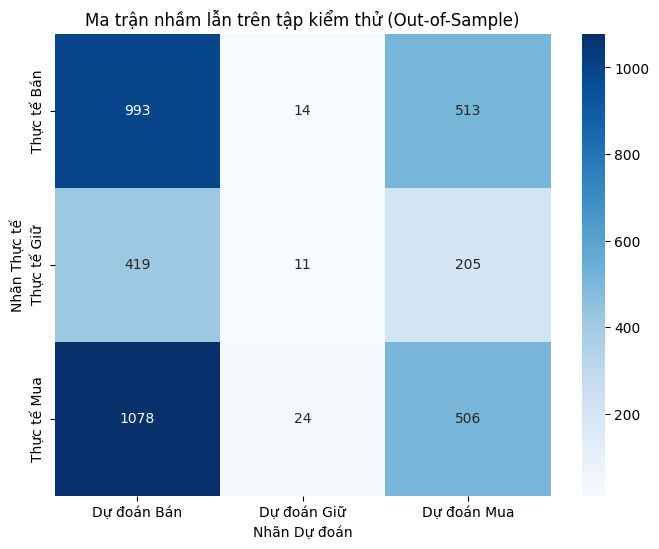


Các đặc trưng quan trọng nhất (từ mô hình được huấn luyện trên 80% dữ liệu):
                feature  importance
43     trend_mass_index        7039
99    log_returns_lag_3        6483
81  momentum_pvo_signal        6241
98    log_returns_lag_2        6239
0         dollar_volume        6230
82    momentum_pvo_hist        6140
44            trend_dpo        6042
3            volume_cmf        5984
97    log_returns_lag_1        5912
53            trend_adx        5832
80         momentum_pvo        5514
9            volume_mfi        5198
21       volatility_kcw        4655
7            volume_vpt        4646
1            volume_adi        4600
52            trend_stc        4393
55        trend_adx_neg        4356
54        trend_adx_pos        4264
30       volatility_atr        4131
47       trend_kst_diff        4107


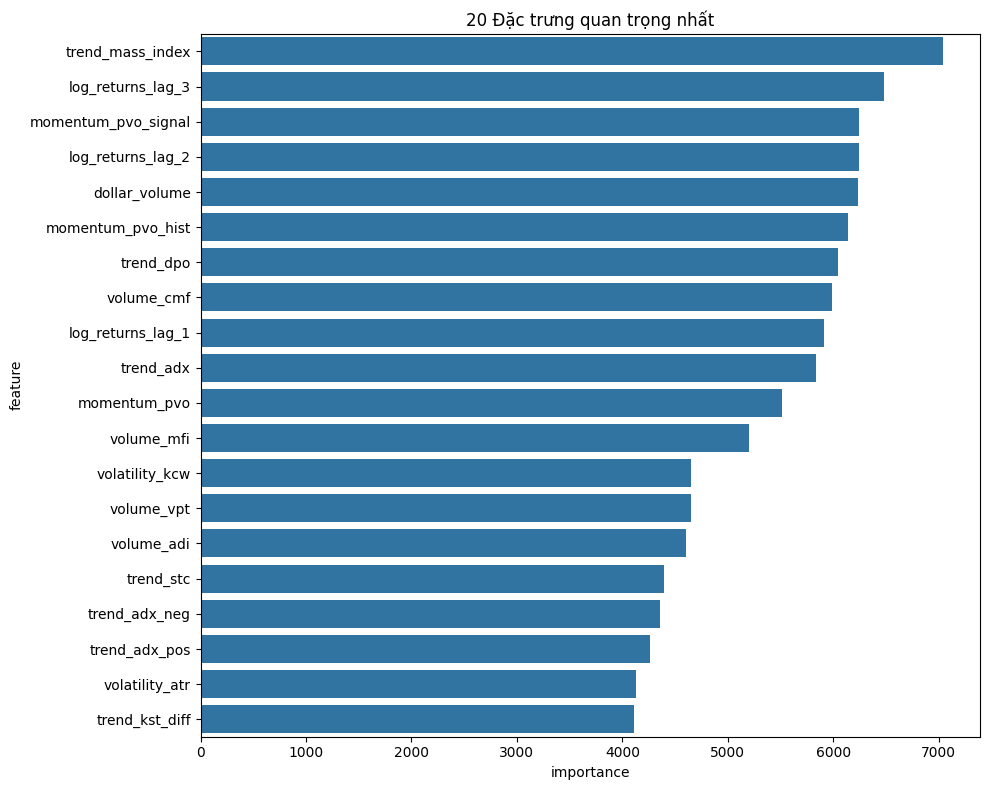

In [107]:
# ======================================================================================
# --- GIAI ĐOẠN 3: TỐI ƯU HÓA & HUẤN LUYỆN MÔ HÌNH ---
# ======================================================================================

# --- Bước 1: Chuẩn bị dữ liệu ---
print("--- Giai đoạn 3, Bước 1: Chuẩn bị dữ liệu (X, y, weights) ---")
# SỬA LỖI: Chọn các cột đặc trưng bằng cách loại trừ các cột không phải là đặc trưng.
# Cách tiếp cận này mạnh mẽ hơn và hoạt động cho cả dữ liệu thực và dữ liệu mẫu.
feature_cols = [col for col in final_dataset.columns if col not in ['label', 'weight']] 
X = final_dataset[feature_cols]
y = final_dataset['label']
weights = final_dataset['weight']
t1 = final_dataset["t1"]

# Xử lý các giá trị `inf` trong `weights`
weights.replace([np.inf, -np.inf], np.nan, inplace=True)
if not weights.dropna().empty:
    max_valid_weight = weights.dropna().max()
    weights.fillna(max_valid_weight, inplace=True)
else:
    weights.fillna(1.0, inplace=True) 

print(f"Dữ liệu đã sẵn sàng với {X.shape[0]} mẫu và {X.shape[1]} đặc trưng.\n")


# --- Bước 2: Định nghĩa hàm Objective cho Optuna với phương pháp Walk-Forward ---
print("--- Giai đoạn 3, Bước 2: Định nghĩa hàm Objective cho Optuna (Walk-Forward) ---")
def objective(trial):
    """
    Hàm này sử dụng phương pháp Walk-Forward CV để đánh giá các siêu tham số.
    """
    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': 3,
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    n_splits = 4 # Chia dữ liệu thành 5 phần: 4 lần huấn luyện/kiểm tra
    f1_scores = []
    
    splits = np.array_split(np.arange(len(X)), n_splits + 1)

    for i in range(n_splits):
        # Thiết lập các tập huấn luyện và kiểm tra cho từng bước đi tới
        train_indices = np.concatenate(splits[:i+1])
        test_indices = splits[i+1]
        
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
        weights_train = weights.iloc[train_indices]

        # Áp dụng cấm vận (Embargo)
        last_train_t1 = t1.iloc[train_indices].max()
        test_start_times = t1.index[test_indices]
        embargo_mask = test_start_times > last_train_t1
        
        X_test = X_test.loc[embargo_mask]
        y_test = y_test.loc[embargo_mask]
        
        if X_train.empty or X_test.empty:
            print(f"  - CẢNH BÁO: Fold {i+1} có tập huấn luyện hoặc kiểm tra rỗng. Bỏ qua fold này.")
            continue

        model = lgb.LGBMClassifier(**params, class_weight='balanced')
        model.fit(X_train, y_train, sample_weight=weights_train)
        
        y_pred = model.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))

    if not f1_scores:
        print("  - LỖI: Tất cả các fold đều tạo ra tập dữ liệu rỗng. Không thể tính điểm số.")
        return 0.0

    return np.mean(f1_scores)

# --- Bước 3: Chạy Optuna Study ---
print("--- Giai đoạn 3, Bước 3: Bắt đầu quá trình tối ưu hóa với Optuna ---")
study = optuna.create_study(direction='maximize')
# Chạy 30 lần thử nghiệm (bạn có thể tăng lên sau khi xác nhận pipeline chạy ổn định)
study.optimize(objective, n_trials=30, n_jobs=-1) 
print("Hoàn thành quá trình tối ưu hóa.\n")


# --- Bước 4: Phân tích kết quả ---
print("--- Giai đoạn 3, Bước 4: Phân tích kết quả tối ưu hóa ---")

print(f"Số lần thử nghiệm đã hoàn thành: {len(study.trials)}")
print("Kết quả tốt nhất:")
best_trial = study.best_trial
print(f"  - Giá trị (Weighted F1-score): {best_trial.value:.5f}")
print("  - Các tham số tốt nhất:")
best_params = best_trial.params
for key, value in best_params.items():
    print(f"    - {key}: {value}")

# Thêm các tham số cố định
best_params['objective'] = 'multiclass'
best_params['metric'] = 'multi_logloss'
best_params['num_class'] = 3
best_params['verbosity'] = -1
best_params['class_weight'] = 'balanced'


# ======================================================================================
# --- GIAI ĐOẠN 4 (MỚI): KIỂM THỬ TRÊN DỮ LIỆU NGOÀI MẪU (OUT-OF-SAMPLE) ---
# ======================================================================================
print("\n--- Bắt đầu Giai đoạn 4: Kiểm thử trên dữ liệu Ngoài Mẫu (Out-of-Sample) ---")

# --- Bước 5: Chia dữ liệu theo thời gian ---
# Sử dụng 80% dữ liệu đầu tiên để huấn luyện và 20% cuối cùng để kiểm thử.
# Điều này mô phỏng việc triển khai mô hình trong thực tế.
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
weights_train = weights.iloc[:train_size]

print(f"Kích thước tập huấn luyện: {len(X_train)} mẫu")
print(f"Kích thước tập kiểm thử: {len(X_test)} mẫu\n")

# --- Bước 6: Huấn luyện lại mô hình cuối cùng trên tập huấn luyện mới ---
print("Huấn luyện lại mô hình cuối cùng trên tập huấn luyện 80%...")
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train, y_train, sample_weight=weights_train)
print("Mô hình đã được huấn luyện lại.\n")

# --- Bước 7: Thực hiện dự đoán và đánh giá trên tập kiểm thử ---
print("--- Kết quả đánh giá trên tập kiểm thử 20% (Out-of-Sample) ---")
y_pred_test = final_model.predict(X_test)

# Hiển thị báo cáo phân loại
print("\nBáo cáo phân loại trên tập kiểm thử:")
print(classification_report(y_test, y_pred_test, labels=[-1, 0, 1], target_names=['Bán (-1)', 'Giữ (0)', 'Mua (1)'], zero_division=0))

# Vẽ ma trận nhầm lẫn
print("\nĐang vẽ ma trận nhầm lẫn cho tập kiểm thử...")
cm = confusion_matrix(y_test, y_pred_test, labels=[-1, 0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Dự đoán Bán', 'Dự đoán Giữ', 'Dự đoán Mua'], 
            yticklabels=['Thực tế Bán', 'Thực tế Giữ', 'Thực tế Mua'])
plt.title('Ma trận nhầm lẫn trên tập kiểm thử (Out-of-Sample)')
plt.ylabel('Nhãn Thực tế')
plt.xlabel('Nhãn Dự đoán')
plt.show()

# --- Bước 8: Hiển thị lại các đặc trưng quan trọng ---
print("\nCác đặc trưng quan trọng nhất (từ mô hình được huấn luyện trên 80% dữ liệu):")
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': final_model.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False).head(20)
print(feature_importances)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('20 Đặc trưng quan trọng nhất')
plt.tight_layout()
plt.show()


--- Bắt đầu Giai đoạn 5: Xây dựng và Kiểm thử Meta Model ---
Kích thước tập huấn luyện đầy đủ: 15050 mẫu
Kích thước tập kiểm thử: 3763 mẫu

Tạo dự đoán Ngoài Mẫu (OOS) cho Meta Model bằng Walk-Forward CV...
  - Fold 1/4: Huấn luyện trên 3010 mẫu, Xác thực trên 3010 mẫu.
  - Fold 2/4: Huấn luyện trên 6020 mẫu, Xác thực trên 3010 mẫu.
  - Fold 3/4: Huấn luyện trên 9030 mẫu, Xác thực trên 3010 mẫu.
  - Fold 4/4: Huấn luyện trên 12040 mẫu, Xác thực trên 3010 mẫu.
Đã tạo xong các dự đoán Ngoài Mẫu.

Tạo nhãn cho Meta Model...
Đã tạo được 10482 nhãn cho Meta Model.
Phân bổ nhãn meta: 
0    6157
1    4325
Name: count, dtype: int64

Huấn luyện Meta Model...
Meta Model đã được huấn luyện.

--- Đánh giá chiến lược kết hợp trên tập kiểm thử 20% ---
Huấn luyện lại mô hình chính trên toàn bộ tập huấn luyện 80%...
Đã có dự đoán từ mô hình chính trên tập kiểm thử.


--- Tối ưu hóa Ngưỡng Tin cậy của Meta Model ---
Kết quả của việc thay đổi ngưỡng tin cậy:
   threshold  num_trades  precision_buy  pre

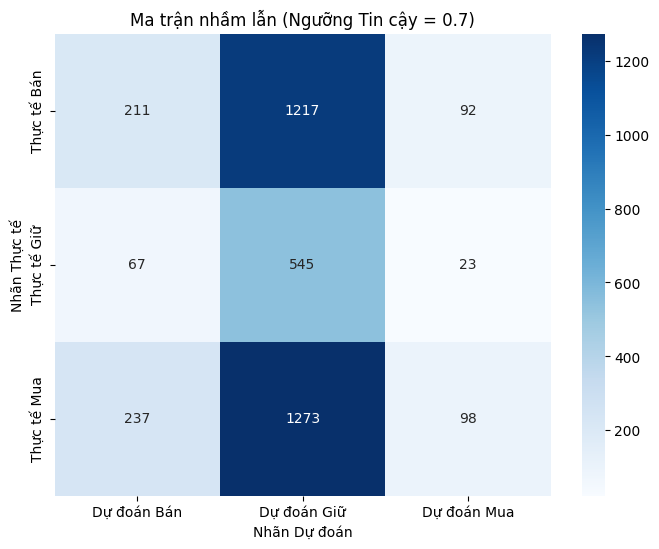

In [114]:
# ======================================================================================
# --- GIAI ĐOẠN 5: META-LABELING ---
# ======================================================================================
print("\n--- Bắt đầu Giai đoạn 5: Xây dựng và Kiểm thử Meta Model ---")

# --- Bước 1: Chia dữ liệu Train/Test như Giai đoạn 4 ---
feature_cols = [col for col in final_dataset.columns if col not in ['label', 'weight']] 
X = final_dataset[feature_cols]
y = final_dataset['label']
weights = final_dataset['weight']

train_size = int(len(X) * 0.8)
X_train_full, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train_full, y_test = y.iloc[:train_size], y.iloc[train_size:]
weights_train_full = weights.iloc[:train_size]

print(f"Kích thước tập huấn luyện đầy đủ: {len(X_train_full)} mẫu")
print(f"Kích thước tập kiểm thử: {len(X_test)} mẫu\n")

# --- Bước 2: Tạo dự đoán Ngoài Mẫu (Out-of-Sample) cho Meta-Labeling ---
print("Tạo dự đoán Ngoài Mẫu (OOS) cho Meta Model bằng Walk-Forward CV...")
primary_model = lgb.LGBMClassifier(**best_params)

n_splits = 4 # Chia tập huấn luyện 80% thành 5 phần
splits = np.array_split(np.arange(len(X_train_full)), n_splits + 1)
primary_preds_oos = []

for i in range(n_splits):
    # Thiết lập các tập huấn luyện và xác thực cho từng bước đi tới
    train_indices = np.concatenate(splits[:i+1])
    val_indices = splits[i+1]
    
    X_train_cv, X_val_cv = X_train_full.iloc[train_indices], X_train_full.iloc[val_indices]
    y_train_cv, y_val_cv = y_train_full.iloc[train_indices], y_train_full.iloc[val_indices]
    weights_train_cv = weights_train_full.iloc[train_indices]

    print(f"  - Fold {i+1}/{n_splits}: Huấn luyện trên {len(X_train_cv)} mẫu, Xác thực trên {len(X_val_cv)} mẫu.")
    
    # Huấn luyện mô hình chính trên tập huấn luyện của fold hiện tại
    primary_model.fit(X_train_cv, y_train_cv, sample_weight=weights_train_cv)
    
    # Dự đoán trên tập xác thực của fold (đây là dự đoán OOS)
    val_preds = pd.Series(primary_model.predict(X_val_cv), index=X_val_cv.index)
    primary_preds_oos.append(val_preds)

# Nối tất cả các dự đoán OOS lại với nhau
primary_pred_train = pd.concat(primary_preds_oos)
print("Đã tạo xong các dự đoán Ngoài Mẫu.\n")


# --- Bước 3: Tạo Nhãn cho Meta Model ---
print("Tạo nhãn cho Meta Model...")
# Lọc ra các dự đoán không phải 'Giữ' (0)
actionable_mask_train = primary_pred_train != 0
primary_pred_train_actionable = primary_pred_train[actionable_mask_train]

# Tạo nhãn meta: 1 nếu dự đoán của mô hình chính ĐÚNG, 0 nếu SAI.
y_train_filtered = y_train_full.loc[primary_pred_train_actionable.index]
meta_y_train = (primary_pred_train_actionable * y_train_filtered > 0).astype(int)

# Tạo đặc trưng cho meta model (sử dụng cùng bộ đặc trưng)
meta_X_train = X_train_full.loc[meta_y_train.index]

print(f"Đã tạo được {len(meta_y_train)} nhãn cho Meta Model.")
print(f"Phân bổ nhãn meta: \n{meta_y_train.value_counts()}\n")

# --- Bước 4: Huấn luyện Meta Model ---
print("Huấn luyện Meta Model...")
meta_model = lgb.LGBMClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1)
if not meta_X_train.empty:
    meta_model.fit(meta_X_train, meta_y_train)
    print("Meta Model đã được huấn luyện.\n")
else:
    print("CẢNH BÁO: Không có đủ dữ liệu để huấn luyện Meta Model. Bỏ qua.\n")


# --- Bước 5: Đánh giá Chiến lược Kết hợp trên Tập Kiểm thử ---
print("--- Đánh giá chiến lược kết hợp trên tập kiểm thử 20% ---")
# 1. Huấn luyện lại mô hình chính trên TOÀN BỘ tập huấn luyện 80% để có dự đoán tốt nhất
print("Huấn luyện lại mô hình chính trên toàn bộ tập huấn luyện 80%...")
primary_model.fit(X_train_full, y_train_full, sample_weight=weights_train_full)
primary_pred_test = pd.Series(primary_model.predict(X_test), index=X_test.index)
print("Đã có dự đoán từ mô hình chính trên tập kiểm thử.\n")


# 2. Lấy xác suất thành công từ Meta Model
actionable_mask_test = primary_pred_test != 0
X_test_actionable = X_test.loc[actionable_mask_test]

# --- Bước 6 (MỚI): Tối ưu hóa Ngưỡng Tin cậy ---
print("\n--- Tối ưu hóa Ngưỡng Tin cậy của Meta Model ---")
if not X_test_actionable.empty and 'meta_model' in locals():
    meta_pred_prob_test = pd.Series(meta_model.predict_proba(X_test_actionable)[:, 1], index=X_test_actionable.index)

    # Thử nghiệm với các ngưỡng khác nhau
    thresholds = [0.50, 0.55, 0.60, 0.65, 0.70]
    results = []

    for threshold in thresholds:
        confident_indices = meta_pred_prob_test[meta_pred_prob_test > threshold].index
        
        final_predictions = pd.Series(0, index=X_test.index)
        if not confident_indices.empty:
            final_predictions.loc[confident_indices] = primary_pred_test.loc[confident_indices]
        
        # Chỉ tính precision cho các lớp có tín hiệu
        precision_buy = precision_score(y_test, final_predictions, labels=[1], average='micro', zero_division=0)
        precision_sell = precision_score(y_test, final_predictions, labels=[-1], average='micro', zero_division=0)
        num_trades = (final_predictions != 0).sum()
        
        results.append({
            'threshold': threshold,
            'num_trades': num_trades,
            'precision_buy': precision_buy,
            'precision_sell': precision_sell
        })

    results_df = pd.DataFrame(results)
    print("Kết quả của việc thay đổi ngưỡng tin cậy:")
    print(results_df)

    # Hiển thị báo cáo chi tiết cho ngưỡng tốt nhất (ví dụ, ngưỡng có precision cao nhất)
    # Tìm ngưỡng có tổng precision cao nhất (ví dụ)
    best_threshold_row = results_df.loc[(results_df['precision_buy'] + results_df['precision_sell']).idxmax()]
    best_threshold = best_threshold_row['threshold']
    print(f"\n--- Phân tích chi tiết cho ngưỡng tốt nhất ({best_threshold}) ---")

    confident_indices_best = meta_pred_prob_test[meta_pred_prob_test > best_threshold].index
    final_predictions_best = pd.Series(0, index=X_test.index)
    if not confident_indices_best.empty:
        final_predictions_best.loc[confident_indices_best] = primary_pred_test.loc[confident_indices_best]

    print("\nBáo cáo phân loại của Chiến lược Kết hợp với ngưỡng tốt nhất:")
    print(classification_report(y_test, final_predictions_best, labels=[-1, 0, 1], target_names=['Bán (-1)', 'Giữ (0)', 'Mua (1)'], zero_division=0))

    print("\nĐang vẽ ma trận nhầm lẫn của Chiến lược Kết hợp với ngưỡng tốt nhất...")
    cm = confusion_matrix(y_test, final_predictions_best, labels=[-1, 0, 1])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Dự đoán Bán', 'Dự đoán Giữ', 'Dự đoán Mua'], 
                yticklabels=['Thực tế Bán', 'Thực tế Giữ', 'Thực tế Mua'])
    plt.title(f'Ma trận nhầm lẫn (Ngưỡng Tin cậy = {best_threshold})')
    plt.ylabel('Nhãn Thực tế')
    plt.xlabel('Nhãn Dự đoán')
    plt.show()

else:
    print("Không có tín hiệu Mua/Bán nào từ Mô hình Chính trên tập kiểm thử hoặc Meta Model chưa được huấn luyện.")

